# Hospital Mortality Prediction Milestone - 3
> ## Model preprocessing and Feature engineering stage

In [1]:
# Importing important libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2_contingency, chi2

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',None)

In [2]:
df = pd.read_excel('/content/Healthcare_cat_dataset.xlsx')
df.head(2)

,group,ID,outcome,age,gendera,BMI_cat,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,Hyperlipemia,Renal failure,COPD,heart rate at,Pulse rate cat,Sys_cat,Diastolic,respiratory cat,temp_cat,SP O2,urine_cat,hemocrit_cat,RBC_Cat,mch_cat,mchc_Cat,mcv_cta,rdw_cat,leukocytes_cat,platelets_cat,neutriphil_cat,Basophil_cat,Lympho_cat,PT_cat(sec),INR_cat,NT_cat,CK_cat,Creatinine_cat,UN_cat,Glu_cat,potas_cat,sodium_cat,cal_cat,chloride_cat,anion_cat,Mag_cat,ph_cat,Biccarbon_cat,metcat,lactic_cat,pco2_cat,ef_cat
0,1,125047,0.0,72,1,0,0,0,0,1,1,0,1,1,0,1,1.0,1,1,1,0,1,0,0,0,1,0,1,0,1,1,0,0,1,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,1,1
1,1,139812,0.0,75,2,0,0,0,0,0,1,0,0,0,1,0,1.0,1,1,1,0,1,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,1,0,1,1,0,1,1,1,1,0,0,0,0,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1177 entries, 0 to 1176
Data columns (total 53 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   group               1177 non-null   int64  
 1   ID                  1177 non-null   int64  
 2   outcome             1176 non-null   float64
 3   age                 1177 non-null   int64  
 4   gendera             1177 non-null   int64  
 5   BMI_cat             1177 non-null   int64  
 6   hypertensive        1177 non-null   int64  
 7   atrialfibrillation  1177 non-null   int64  
 8   CHD with no MI      1177 non-null   int64  
 9   diabetes            1177 non-null   int64  
 10  deficiencyanemias   1177 non-null   int64  
 11  depression          1177 non-null   int64  
 12  Hyperlipemia        1177 non-null   int64  
 13  Renal failure       1177 non-null   int64  
 14  COPD                1177 non-null   int64  
 15  heart rate at       1177 non-null   int64  
 16  Pulse 

In [4]:
# Checking for null values - overview
df.isnull().sum().values.sum()

17

In [5]:
# Checking for null values - indepth
df.isnull().sum()

group                  0
ID                     0
outcome                1
age                    0
gendera                0
BMI_cat                0
hypertensive           0
atrialfibrillation     0
CHD with no MI         0
diabetes               0
deficiencyanemias      0
depression             0
Hyperlipemia           0
Renal failure          0
COPD                   0
heart rate at          0
Pulse rate cat        16
Sys_cat                0
Diastolic              0
respiratory cat        0
temp_cat               0
SP O2                  0
urine_cat              0
hemocrit_cat           0
RBC_Cat                0
mch_cat                0
mchc_Cat               0
mcv_cta                0
rdw_cat                0
leukocytes_cat         0
platelets_cat          0
neutriphil_cat         0
Basophil_cat           0
Lympho_cat             0
PT_cat(sec)            0
INR_cat                0
NT_cat                 0
CK_cat                 0
Creatinine_cat         0
UN_cat                 0


In [6]:
# Imputing null values with mode
df['outcome'].fillna(df['outcome'].mode()[0], inplace=True)
df['Pulse rate cat'].fillna(df['Pulse rate cat'].mode()[0], inplace=True)

In [7]:
# Verifying imputation process
df.isnull().sum().values.sum()

0

In [8]:
df['Pulse rate cat'] = df['Pulse rate cat'].astype('int64')
df['outcome'] = df['outcome'].astype('int64')

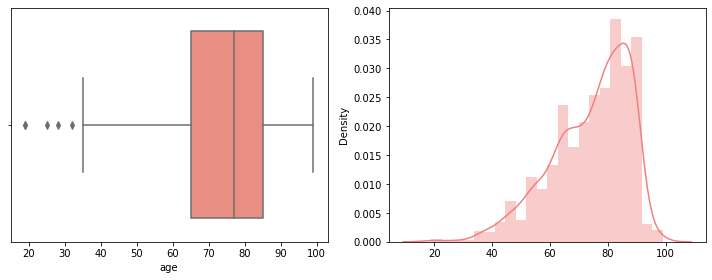

In [9]:
# checking for outliers in 'age' column
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
sns.boxplot(x=df['age'], color='salmon')

plt.subplot(1, 2, 2)
sns.distplot(x=df['age'], color='lightcoral')
plt.tight_layout()
plt.show()

In [10]:
# Outlier Treatment - (Capping process)
q1 = df['age'].quantile(0.25)
q3 = df['age'].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

df['age'] = np.where(df['age'] > upper_bound, upper_bound, np.where(df['age'] < lower_bound, lower_bound, df['age']))

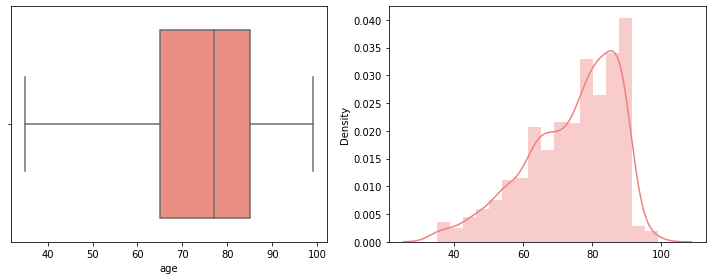

In [11]:
# Verifying outlier treatment
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
sns.boxplot(x=df['age'], color='salmon')

plt.subplot(1, 2, 2)
sns.distplot(x=df['age'], color='lightcoral')
plt.tight_layout()
plt.show()

In [12]:
# Function to calculate percentage in cross tab output
def percentage(crosstb):
  per_list = []
  for i in range(len(crosstb)):
    ans = crosstb.iloc[i, 1] / sum(crosstb.iloc[i]) * 100
    per_list.append(ans)
  return per_list

## Feature Creation

In [13]:
df_new = df.copy(deep=True)

In [14]:
def impact(col):
  alpha = 0.05
  # Contingency Table
  contingency_table = pd.crosstab(df_new[col], df_new['outcome'])
  # Observed Values
  observed_values = contingency_table.values
  # Expected Values
  exp = chi2_contingency(contingency_table)
  expected_val = exp[3]
  # Degree of freedom
  dof = exp[2]
  # Chi-square statistics - X2
  chi_square = sum([(o-e)**2/e for o, e in zip(observed_values, expected_val)])
  chi_square_statistic = chi_square[0] + chi_square[1]
  # Critical value
  critical_value = chi2.ppf(q=1-alpha, df=dof)
  # p-value
  p_value = 1 - chi2.cdf(x=chi_square_statistic, df=dof)
  
  return round(chi_square_statistic, 5), round(critical_value, 5), round(p_value, 5)

### 'age_bin' feature 
- Lets convert age feature into bins of 10y each to 'age_bin' to see weather age has any affect on mortality

In [15]:
# Creating bins for age feature and create a new column
bins = [30, 40, 50, 60, 70, 80, 90, 100]
group_1 = ['30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']
df_new['age_bin'] = pd.cut(df_new['age'], bins, labels = group_1)

df_new.head(2)

,group,ID,outcome,age,gendera,BMI_cat,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,Hyperlipemia,Renal failure,COPD,heart rate at,Pulse rate cat,Sys_cat,Diastolic,respiratory cat,temp_cat,SP O2,urine_cat,hemocrit_cat,RBC_Cat,mch_cat,mchc_Cat,mcv_cta,rdw_cat,leukocytes_cat,platelets_cat,neutriphil_cat,Basophil_cat,Lympho_cat,PT_cat(sec),INR_cat,NT_cat,CK_cat,Creatinine_cat,UN_cat,Glu_cat,potas_cat,sodium_cat,cal_cat,chloride_cat,anion_cat,Mag_cat,ph_cat,Biccarbon_cat,metcat,lactic_cat,pco2_cat,ef_cat,age_bin
0,1,125047,0,72.0,1,0,0,0,0,1,1,0,1,1,0,1,1,1,1,1,0,1,0,0,0,1,0,1,0,1,1,0,0,1,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,1,1,70-80
1,1,139812,0,75.0,2,0,0,0,0,0,1,0,0,0,1,0,1,1,1,1,0,1,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,1,0,1,1,0,1,1,1,1,0,0,0,0,1,70-80


> H0: There is no relation between age_bin and outcome

> H1: There is a relation between age_bin and outcome

In [16]:
chi_square_statistic, critical_value, p_value = impact('age_bin')
print('"age_bin" p-value: ', p_value )

"age_bin" p-value:  0.18964


- We retain the H0, as there is no relationship between age_bin and outcome.

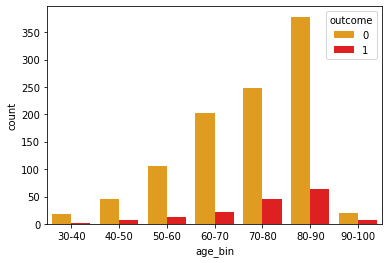

In [17]:
# Count Plot
sns.countplot(df_new['age_bin'], hue = df_new['outcome'], palette=['orange', 'red'])
plt.show()

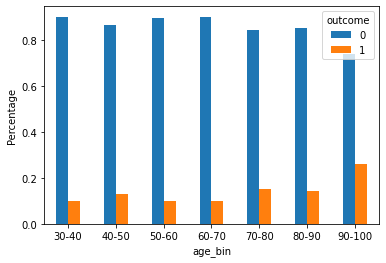

In [18]:
# Percentage Plot
crosstb = pd.crosstab(df_new['age_bin'], df_new['outcome'])
crosstb.div(crosstb.sum(axis=1), axis=0).plot(kind='bar', figsize=(6,4))
plt.xlabel('age_bin')
plt.xticks(rotation=0)
plt.ylabel('Percentage')
plt.show()

In [19]:
# Cross tab
crosstb['Percent(%)'] = percentage(crosstb)
crosstb

outcome,0,1,Percent(%)
age_bin,,,
30-40,18,2,10.000000
40-50,46,7,13.207547
50-60,106,12,10.169492
60-70,202,22,9.821429
70-80,248,45,15.358362
80-90,378,64,14.479638
90-100,20,7,25.925926


- After transforming 'age' feature to 'age_bin' we can see that the p-value is __0.18964__ which tells that we cannot use this feature for training our model.

###'sys_dia' feature
- As 'Sys_cat' and 'Diastolic' both features shows the blood pressure.

In [20]:
# New feature
df_new['sys_dia'] = df_new['Sys_cat'] + df_new['Diastolic']
df_new.head(2)

,group,ID,outcome,age,gendera,BMI_cat,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,Hyperlipemia,Renal failure,COPD,heart rate at,Pulse rate cat,Sys_cat,Diastolic,respiratory cat,temp_cat,SP O2,urine_cat,hemocrit_cat,RBC_Cat,mch_cat,mchc_Cat,mcv_cta,rdw_cat,leukocytes_cat,platelets_cat,neutriphil_cat,Basophil_cat,Lympho_cat,PT_cat(sec),INR_cat,NT_cat,CK_cat,Creatinine_cat,UN_cat,Glu_cat,potas_cat,sodium_cat,cal_cat,chloride_cat,anion_cat,Mag_cat,ph_cat,Biccarbon_cat,metcat,lactic_cat,pco2_cat,ef_cat,age_bin,sys_dia
0,1,125047,0,72.0,1,0,0,0,0,1,1,0,1,1,0,1,1,1,1,1,0,1,0,0,0,1,0,1,0,1,1,0,0,1,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,1,1,70-80,2
1,1,139812,0,75.0,2,0,0,0,0,0,1,0,0,0,1,0,1,1,1,1,0,1,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,1,0,1,1,0,1,1,1,1,0,0,0,0,1,70-80,2


> H0: There is no relation between sys_dia and outcome

> H1: There is a relation between sys_dia and outcome

In [21]:
# p-value
chi_square_statistic, critical_value, p_value = impact('sys_dia')
print('sys_dia p-value: ', p_value)

sys_dia p-value:  0.12965


- We retain the H0, as there is no relationship between sys_dia and outcome.

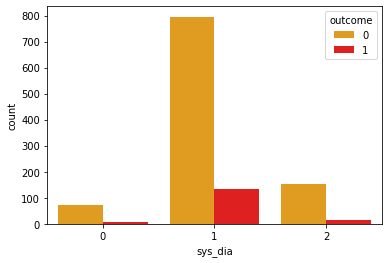

In [22]:
# Count Plot
sns.countplot(df_new['sys_dia'], hue = df_new['outcome'], palette=['orange', 'red'])
plt.show()

- 0: Both are out of range, 1: Either one of them is out of range, 2: Both are in range

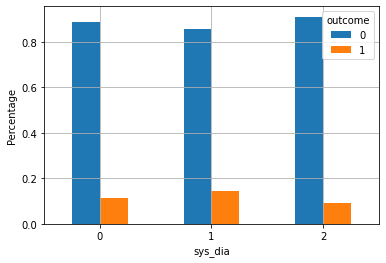

In [23]:
# Percentage graph
crosstb = pd.crosstab(df_new['sys_dia'], df_new['outcome'])
crosstb.div(crosstb.sum(axis=1), axis=0).plot(kind='bar', figsize=(6,4))
plt.xlabel('sys_dia')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.grid()
plt.show()

- 0: Both are out of range, 1: Either one of them is out of range, 2: Both are in range

In [24]:
# Cross tab
crosstb['Percent(%)'] = percentage(crosstb)
crosstb

outcome,0,1,Percent(%)
sys_dia,,,
0,71,9,11.250000
1,795,135,14.516129
2,152,15,8.982036


- After clubbing 'Sys_cat' and 'Diastolic' to 'sys_dia' we can see that the p-value is __0.12965__ which tells that this new column can be used for training our model.

###'anion_bicc' feature
- As 'anion_cat' and 'Biccarbon_cat' both features shows acid-base behaviour.

In [25]:
# New feature
df_new['anion_bicc'] = df_new['anion_cat'] + df_new['Biccarbon_cat']
df_new.head(2)

,group,ID,outcome,age,gendera,BMI_cat,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,Hyperlipemia,Renal failure,COPD,heart rate at,Pulse rate cat,Sys_cat,Diastolic,respiratory cat,temp_cat,SP O2,urine_cat,hemocrit_cat,RBC_Cat,mch_cat,mchc_Cat,mcv_cta,rdw_cat,leukocytes_cat,platelets_cat,neutriphil_cat,Basophil_cat,Lympho_cat,PT_cat(sec),INR_cat,NT_cat,CK_cat,Creatinine_cat,UN_cat,Glu_cat,potas_cat,sodium_cat,cal_cat,chloride_cat,anion_cat,Mag_cat,ph_cat,Biccarbon_cat,metcat,lactic_cat,pco2_cat,ef_cat,age_bin,sys_dia,anion_bicc
0,1,125047,0,72.0,1,0,0,0,0,1,1,0,1,1,0,1,1,1,1,1,0,1,0,0,0,1,0,1,0,1,1,0,0,1,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,1,1,70-80,2,1
1,1,139812,0,75.0,2,0,0,0,0,0,1,0,0,0,1,0,1,1,1,1,0,1,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,1,0,1,1,0,1,1,1,1,0,0,0,0,1,70-80,2,1


> H0: There is no relation between anion_bicc and outcome

> H1: There is a relation between anion_bicc and outcome

In [26]:
# p-value
chi_square_statistic, critical_value, p_value = impact('anion_bicc')
print('anion_bicc p-value: ', p_value)

anion_bicc p-value:  0.0


- We reject the H0, there is a relationship between anion_bicc and outcome.

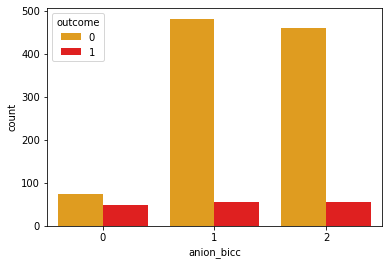

In [27]:
# Count plot
sns.countplot(df_new['anion_bicc'], hue = df_new['outcome'], palette=['orange', 'red'])
plt.show()

- 0: Both are out of range, 1: Either one of them is out of range, 2: Both are in range

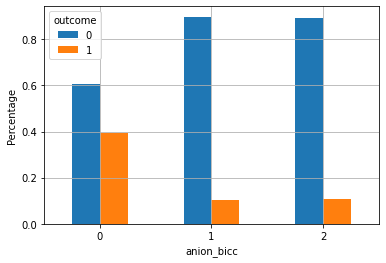

In [28]:
# Percentage graph
crosstb = pd.crosstab(df_new['anion_bicc'], df_new['outcome'])
crosstb.div(crosstb.sum(axis=1), axis=0).plot(kind='bar', figsize=(6,4))
plt.xlabel('anion_bicc')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.grid()
plt.show()

- 0: Both are out of range, 1: Either one of them is out of range, 2: Both are in range

In [29]:
# Cross tab
crosstb['Percent(%)'] = percentage(crosstb)
crosstb

outcome,0,1,Percent(%)
anion_bicc,,,
0,75,49,39.516129
1,482,55,10.242086
2,461,55,10.658915


- After clubbing 'anion_cat' and 'Biccarbon_cat' to 'anion_bicc' we can see that the p-value is 0.00 which tells that this new column can be used for training our model.

## 'ren_un' feature
- As 'Renal failure' and 'UN_cat' both features shows problem with kidney function.

In [30]:
# New feature
df_new['ren_un'] = df_new['Renal failure'] + df_new['UN_cat']
df_new.head(2)

,group,ID,outcome,age,gendera,BMI_cat,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,Hyperlipemia,Renal failure,COPD,heart rate at,Pulse rate cat,Sys_cat,Diastolic,respiratory cat,temp_cat,SP O2,urine_cat,hemocrit_cat,RBC_Cat,mch_cat,mchc_Cat,mcv_cta,rdw_cat,leukocytes_cat,platelets_cat,neutriphil_cat,Basophil_cat,Lympho_cat,PT_cat(sec),INR_cat,NT_cat,CK_cat,Creatinine_cat,UN_cat,Glu_cat,potas_cat,sodium_cat,cal_cat,chloride_cat,anion_cat,Mag_cat,ph_cat,Biccarbon_cat,metcat,lactic_cat,pco2_cat,ef_cat,age_bin,sys_dia,anion_bicc,ren_un
0,1,125047,0,72.0,1,0,0,0,0,1,1,0,1,1,0,1,1,1,1,1,0,1,0,0,0,1,0,1,0,1,1,0,0,1,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,1,1,70-80,2,1,1
1,1,139812,0,75.0,2,0,0,0,0,0,1,0,0,0,1,0,1,1,1,1,0,1,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,1,0,1,1,0,1,1,1,1,0,0,0,0,1,70-80,2,1,1


> H0: There is no relation between ren_un and outcome

> H1: There is a relation between ren_un and outcome

In [31]:
# p-value
chi_square_statistic, critical_value, p_value = impact('ren_un')
print('ren_un  p-value: ', p_value)

ren_un  p-value:  0.0


- We reject the H0, there is a relationship between ren_un and outcome.

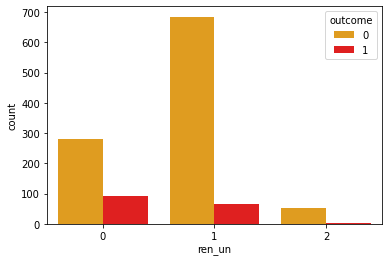

In [32]:
# Count plot
sns.countplot(df_new['ren_un'], hue = df_new['outcome'], palette=['orange', 'red'])
plt.show()

- 0: Both are out of range, 1: Either one of them is out of range, 2: Both are in range

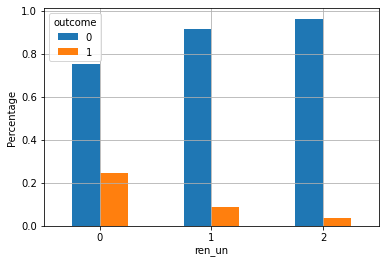

In [33]:
# Percentage graph
crosstb = pd.crosstab(df_new['ren_un'], df_new['outcome'])
crosstb.div(crosstb.sum(axis=1), axis=0).plot(kind='bar', figsize=(6,4))
plt.xlabel('ren_un')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.grid()
plt.show()

- 0: Both are out of range, 1: Either one of them is out of range, 2: Both are in range

In [34]:
# Cross tab
crosstb['Percent(%)'] = percentage(crosstb)
crosstb

outcome,0,1,Percent(%)
ren_un,,,
0,282,92,24.598930
1,685,65,8.666667
2,51,2,3.773585


- After clubbing 'Renal failure' and 'UN_cat' to 'ren_un' we can see that the p-value is 0.00 which tells that this new column can be used for training our model.

## 'neutri_lympho' feature
- As 'neutriphil_cat' and 'Lympho_cat' both features shows a type of WBC count.

In [35]:
# New feature
df_new['neutri_lympho'] = df_new['neutriphil_cat'] + df_new['Lympho_cat']
df_new.head(2)

,group,ID,outcome,age,gendera,BMI_cat,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,Hyperlipemia,Renal failure,COPD,heart rate at,Pulse rate cat,Sys_cat,Diastolic,respiratory cat,temp_cat,SP O2,urine_cat,hemocrit_cat,RBC_Cat,mch_cat,mchc_Cat,mcv_cta,rdw_cat,leukocytes_cat,platelets_cat,neutriphil_cat,Basophil_cat,Lympho_cat,PT_cat(sec),INR_cat,NT_cat,CK_cat,Creatinine_cat,UN_cat,Glu_cat,potas_cat,sodium_cat,cal_cat,chloride_cat,anion_cat,Mag_cat,ph_cat,Biccarbon_cat,metcat,lactic_cat,pco2_cat,ef_cat,age_bin,sys_dia,anion_bicc,ren_un,neutri_lympho
0,1,125047,0,72.0,1,0,0,0,0,1,1,0,1,1,0,1,1,1,1,1,0,1,0,0,0,1,0,1,0,1,1,0,0,1,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,1,1,70-80,2,1,1,1
1,1,139812,0,75.0,2,0,0,0,0,0,1,0,0,0,1,0,1,1,1,1,0,1,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,1,0,1,1,0,1,1,1,1,0,0,0,0,1,70-80,2,1,1,0


> H0: There is no relation between neutri_lympho and outcome

> H1: There is a relation between neutri_lympho and outcome

In [36]:
# p-value
chi_square_statistic, critical_value, p_value = impact('neutri_lympho')
print('neutri_lympho  p-value: ', p_value)

neutri_lympho  p-value:  0.0


- We reject the H0, there is a relationship between neutri_lympho and outcome.

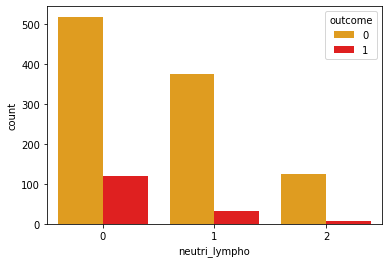

In [37]:
# Count plot
sns.countplot(df_new['neutri_lympho'], hue = df_new['outcome'], palette=['orange', 'red'])
plt.show()

- 0: Both are out of range, 1: Either one of them is out of range, 2: Both are in range

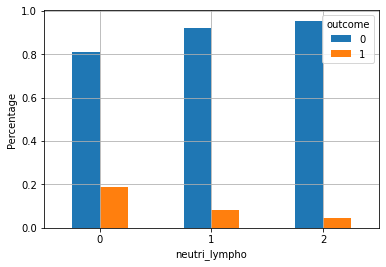

In [38]:
# Percentage graph
crosstb = pd.crosstab(df_new['neutri_lympho'], df_new['outcome'])
crosstb.div(crosstb.sum(axis=1), axis=0).plot(kind='bar', figsize=(6,4))
plt.xlabel('neutri_lympho')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.grid()
plt.show()

- 0: Both are out of range, 1: Either one of them is out of range, 2: Both are in range

In [39]:
# Cross tab
crosstb['Percent(%)'] = percentage(crosstb)
crosstb

outcome,0,1,Percent(%)
neutri_lympho,,,
0,518,120,18.808777
1,376,33,8.068460
2,124,6,4.615385


- After clubbing 'neutriphil_cat' and 'Lympho_cat' to 'neutri_lympho' we can see that the p-value is 0.00 which tells that this new column can be used for training our model.

## 'anemia_rdw' feature
- As 'deficiencyanemias' and 'rdw_cat' both features shows irregularity in RBC count.

In [40]:
# New feature
df_new['anemia_rdw'] = df_new['deficiencyanemias'] + df_new['rdw_cat']
df_new.head(2)

,group,ID,outcome,age,gendera,BMI_cat,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,Hyperlipemia,Renal failure,COPD,heart rate at,Pulse rate cat,Sys_cat,Diastolic,respiratory cat,temp_cat,SP O2,urine_cat,hemocrit_cat,RBC_Cat,mch_cat,mchc_Cat,mcv_cta,rdw_cat,leukocytes_cat,platelets_cat,neutriphil_cat,Basophil_cat,Lympho_cat,PT_cat(sec),INR_cat,NT_cat,CK_cat,Creatinine_cat,UN_cat,Glu_cat,potas_cat,sodium_cat,cal_cat,chloride_cat,anion_cat,Mag_cat,ph_cat,Biccarbon_cat,metcat,lactic_cat,pco2_cat,ef_cat,age_bin,sys_dia,anion_bicc,ren_un,neutri_lympho,anemia_rdw
0,1,125047,0,72.0,1,0,0,0,0,1,1,0,1,1,0,1,1,1,1,1,0,1,0,0,0,1,0,1,0,1,1,0,0,1,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,1,1,70-80,2,1,1,1,1
1,1,139812,0,75.0,2,0,0,0,0,0,1,0,0,0,1,0,1,1,1,1,0,1,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,1,0,1,1,0,1,1,1,1,0,0,0,0,1,70-80,2,1,1,0,2


> H0: There is no relation between anemia_rdw and outcome

> H1: There is a relation between anemia_rdw and outcome

In [41]:
# p-value
chi_square_statistic, critical_value, p_value = impact('anemia_rdw')
print('anemia_rdw  p-value: ', p_value)

anemia_rdw  p-value:  0.0


- We reject the H0, there is a relationship between anemia_rdw and outcome.

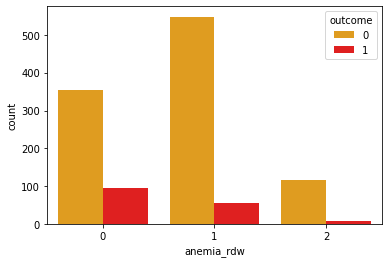

In [42]:
# Count plot
sns.countplot(df_new['anemia_rdw'], hue = df_new['outcome'], palette=['orange', 'red'])
plt.show()

- 0: Both are out of range, 1: Either one of them is out of range, 2: Both are in range

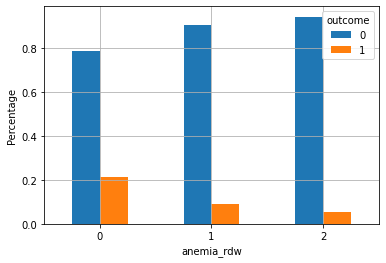

In [43]:
# Percentage graph
crosstb = pd.crosstab(df_new['anemia_rdw'], df_new['outcome'])
crosstb.div(crosstb.sum(axis=1), axis=0).plot(kind='bar', figsize=(6,4))
plt.xlabel('anemia_rdw')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.grid()
plt.show()

- 0: Both are out of range, 1: Either one of them is out of range, 2: Both are in range

In [44]:
# Cross tab
crosstb['Percent(%)'] = percentage(crosstb)
crosstb

outcome,0,1,Percent(%)
anemia_rdw,,,
0,353,96,21.380846
1,548,56,9.271523
2,117,7,5.645161


- After clubbing 'deficiencyanemias' and 'rdw_cat' to 'anemia_rdw' we can see that the p-value is 0.00 which tells that this new column can be used for training our model.

In [45]:
df_new.shape

(1177, 59)

## Removing unwanted features

- After our analysis we will now drop all the columns where H0 is getting retained.

In [46]:
for col in df_new.columns:
  chi_square_statistic, critical_value, p_value = impact(col)
  if p_value > 0.05:
    df_new.drop([col], axis=1, inplace=True)

df_new.shape

(1177, 35)

> Also removing those features which were used to crete new feature which got selected for training our model.

In [47]:
df_new.head(2)

,outcome,hypertensive,atrialfibrillation,deficiencyanemias,depression,Renal failure,Pulse rate cat,Sys_cat,Diastolic,respiratory cat,temp_cat,urine_cat,mcv_cta,rdw_cat,leukocytes_cat,platelets_cat,neutriphil_cat,Basophil_cat,Lympho_cat,PT_cat(sec),Creatinine_cat,UN_cat,potas_cat,sodium_cat,cal_cat,chloride_cat,anion_cat,ph_cat,Biccarbon_cat,metcat,pco2_cat,anion_bicc,ren_un,neutri_lympho,anemia_rdw
0,0,0,0,1,0,1,1,1,1,1,0,0,1,0,1,1,0,0,1,0,0,0,1,1,0,0,1,1,0,0,1,1,1,1,1
1,0,0,0,1,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,0,0,0,1,1,0,2


In [48]:
df_final = df_new.drop(columns=['deficiencyanemias', 'rdw_cat', 'neutriphil_cat', 'Lympho_cat', 'UN_cat', 'Renal failure', 'anion_cat', 'Biccarbon_cat'], axis=1)
df_final.head(2)

,outcome,hypertensive,atrialfibrillation,depression,Pulse rate cat,Sys_cat,Diastolic,respiratory cat,temp_cat,urine_cat,mcv_cta,leukocytes_cat,platelets_cat,Basophil_cat,PT_cat(sec),Creatinine_cat,potas_cat,sodium_cat,cal_cat,chloride_cat,ph_cat,metcat,pco2_cat,anion_bicc,ren_un,neutri_lympho,anemia_rdw
0,0,0,0,0,1,1,1,1,0,0,1,1,1,0,0,0,1,1,0,0,1,0,1,1,1,1,1
1,0,0,0,0,1,1,1,1,0,1,1,0,1,0,0,1,1,1,0,1,1,0,0,1,1,0,2


In [49]:
df_final.shape

(1177, 27)

In [50]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1177 entries, 0 to 1176
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   outcome             1177 non-null   int64
 1   hypertensive        1177 non-null   int64
 2   atrialfibrillation  1177 non-null   int64
 3   depression          1177 non-null   int64
 4   Pulse rate cat      1177 non-null   int64
 5   Sys_cat             1177 non-null   int64
 6   Diastolic           1177 non-null   int64
 7   respiratory cat     1177 non-null   int64
 8   temp_cat            1177 non-null   int64
 9   urine_cat           1177 non-null   int64
 10  mcv_cta             1177 non-null   int64
 11  leukocytes_cat      1177 non-null   int64
 12  platelets_cat       1177 non-null   int64
 13  Basophil_cat        1177 non-null   int64
 14  PT_cat(sec)         1177 non-null   int64
 15  Creatinine_cat      1177 non-null   int64
 16  potas_cat           1177 non-null   int64
